In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up one level to `project` directory

In [2]:
import data.shots_data_retriever as shots_data_retriever
import importlib

importlib.reload(shots_data_retriever)

shotsDataRetriever = shots_data_retriever.ShotsDataRetriever()

df = shotsDataRetriever.get_df_for_milestone2_part2()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.calibration import calibration_curve, CalibrationDisplay

### Clean dataset

In [4]:
df = df.dropna(subset=['distance', 'is_goal'])

### Split dataset (train + test)

In [5]:
X = df[['distance']]
y = df['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train

,distance
39440,61.741396
25267,15.297059
59007,41.109610
62182,16.643317
11389,18.439089
...,...
44928,13.453624
21880,43.174066
56981,24.515301
71916,56.320511


### Training

In [6]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

### Evaluation

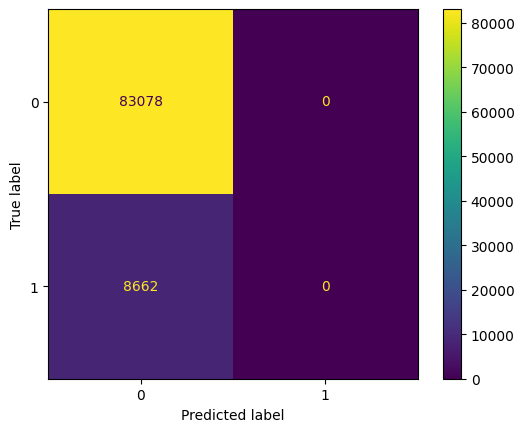

0.9055809897536516
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     83078
           1       0.00      0.00      0.00      8662

    accuracy                           0.91     91740
   macro avg       0.45      0.50      0.48     91740
weighted avg       0.82      0.91      0.86     91740



In [7]:
y_pred = clf.predict(X_test) # Predict on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0.0)
confusion_m  = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_m, display_labels=[0, 1])
disp.plot()
plt.show()

print(accuracy)
print(report)

In [8]:
y_proba = clf.predict_proba(X_test)
non_goal_proba = [proba[0] for proba in y_proba]
goal_proba = [proba[1] for proba in y_proba]

proba_df = X_test.copy()
proba_df['non_goal_proba'] = non_goal_proba
proba_df['goal_proba'] = goal_proba
proba_df['is_goal'] = y_test

proba_df

,distance,non_goal_proba,goal_proba,is_goal
2389,34.525353,0.921852,0.078148,0
74406,10.295630,0.813129,0.186871,0
22156,10.816654,0.816365,0.183635,0
45262,23.021729,0.880196,0.119804,1
51988,7.280110,0.793532,0.206468,1
...,...,...,...,...
73454,36.055513,0.926270,0.073730,0
57138,49.162994,0.955650,0.044350,0
14992,51.078371,0.958874,0.041126,0
23819,58.249464,0.969060,0.030940,0


### Courbe ROC

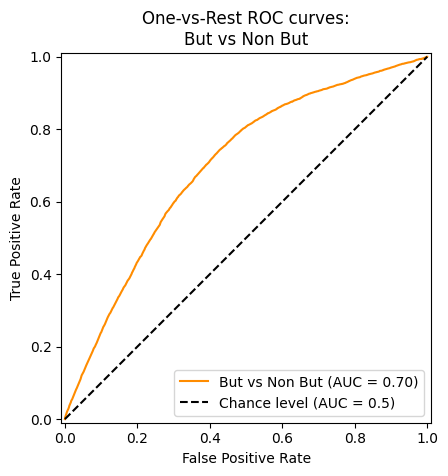

In [9]:
display = RocCurveDisplay.from_predictions(
    y_test,
    proba_df['goal_proba'],
    name=f"But vs Non But",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nBut vs Non But",
)

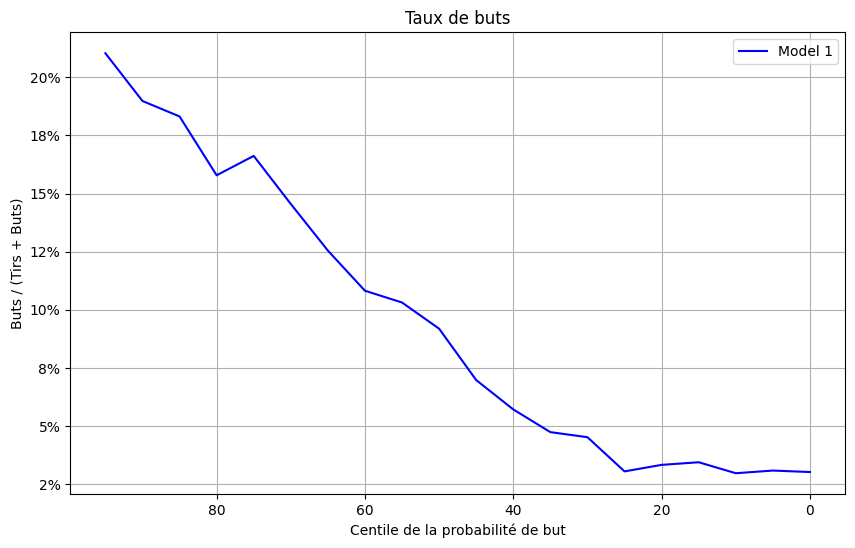

In [10]:
gr_df = proba_df.copy()

percentile_bins = np.linspace(0, 1, 21)
gr_df['percentile'] = pd.qcut(gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goal_rates, color='blue', label='Model 1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

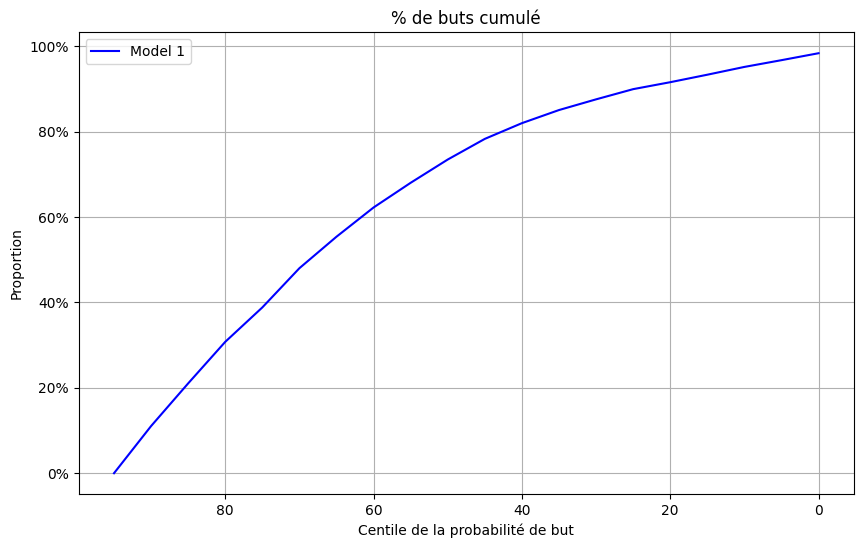

In [11]:
cg_df = proba_df.copy()

percentile_bins = np.linspace(0, 1, 21)
cg_df['percentile'] = pd.qcut(cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
total_shots = cg_df['is_goal'].sum()
goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='Model 1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

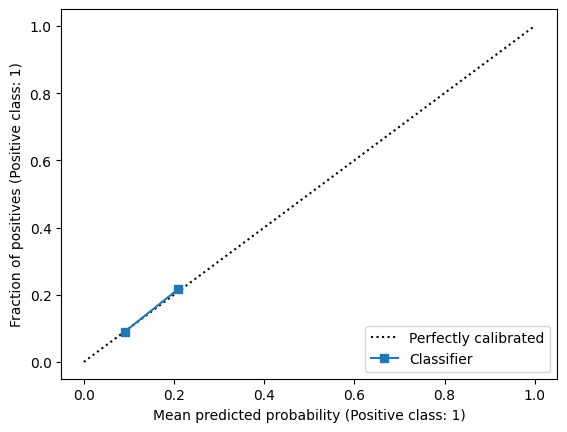

In [12]:
disp = CalibrationDisplay.from_predictions(y_test, proba_df['goal_proba'])
plt.show()

### Régression logistique

In [13]:
def get_percentile_and_goal_proba(features):
    X = df[features]
    y = df['is_goal']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_proba = model.predict_proba(X_test)
    non_goal_proba = [proba[0] for proba in y_proba]
    goal_proba = [proba[1] for proba in y_proba]

    proba_df = X_test.copy()
    proba_df['non_goal_proba'] = non_goal_proba
    proba_df['goal_proba'] = goal_proba
    proba_df['is_goal'] = y_test
    
    percentile_bins = np.linspace(0, 1, 21)
    proba_df['percentile'] = pd.qcut(proba_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
    return percentile_bins, proba_df

#### ROC

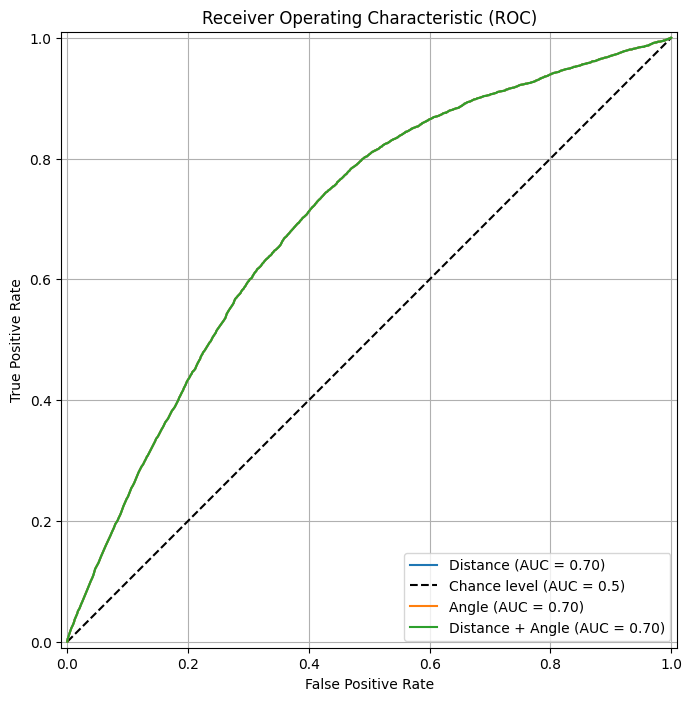

In [14]:
plt.figure(figsize=(10, 8))

percentile_bins, probadf = get_percentile_and_goal_proba(['distance'])
display = RocCurveDisplay.from_predictions(
    y_test,
    proba_df['goal_proba'],
    name='Distance',
    plot_chance_level=True,
    ax=plt.gca()
)

percentile_bins, probadf = get_percentile_and_goal_proba(['angle_to_goal'])
display = RocCurveDisplay.from_predictions(
    y_test,
    proba_df['goal_proba'],
    name='Angle',
    plot_chance_level=False,
    ax=plt.gca()
)

percentile_bins, probadf = get_percentile_and_goal_proba(['distance', 'angle_to_goal'])
display = RocCurveDisplay.from_predictions(
    y_test,
    proba_df['goal_proba'],
    name='Distance + Angle',
    plot_chance_level=False,
    ax=plt.gca()
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### Taux de buts

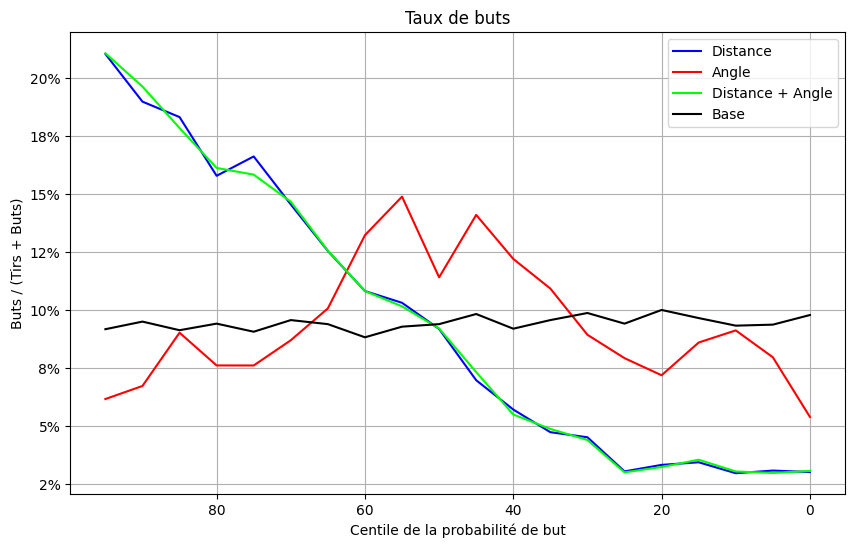

In [15]:
plt.figure(figsize=(10, 6))

# Distance only
percentile_bins, probadf = get_percentile_and_goal_proba(['distance'])
goal_rates_distance = probadf.groupby('percentile', observed=False)['is_goal'].mean()

plt.plot(percentile_bins[:-1], goal_rates_distance, color='blue', label='Distance')

# Angle only
percentile_bins, probadf = get_percentile_and_goal_proba(['angle_to_goal'])
goal_rates_angle = probadf.groupby('percentile', observed=False)['is_goal'].mean()

plt.plot(percentile_bins[:-1], goal_rates_angle, color='red', label='Angle')

# Distance + Angle
percentile_bins, probadf = get_percentile_and_goal_proba(['distance', 'angle_to_goal'])
goal_rates_angle_distance = probadf.groupby('percentile', observed=False)['is_goal'].mean()

plt.plot(percentile_bins[:-1], goal_rates_angle_distance, color='lime', label='Distance + Angle')

# Ligne de base aleatoire
np.random.seed(0)
proba_df = pd.DataFrame({
    'goal_proba': np.random.rand(1000),  # Model's predicted probabilities
    'is_goal': np.random.binomial(1, 0.2, 1000)  # Binary goal indicator (20% goal rate)
})

probadf['goal_proba'] = np.random.uniform(0, 1, size=len(probadf['goal_proba']))
probadf['percentile'] = pd.qcut(probadf['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]) 
goal_rates_angle_distance = probadf.groupby('percentile', observed=False)['is_goal'].mean()

plt.plot(percentile_bins[:-1], goal_rates_angle_distance, color='black', label='Base')

# Show figure
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

#### Proportion cumuluée de buts

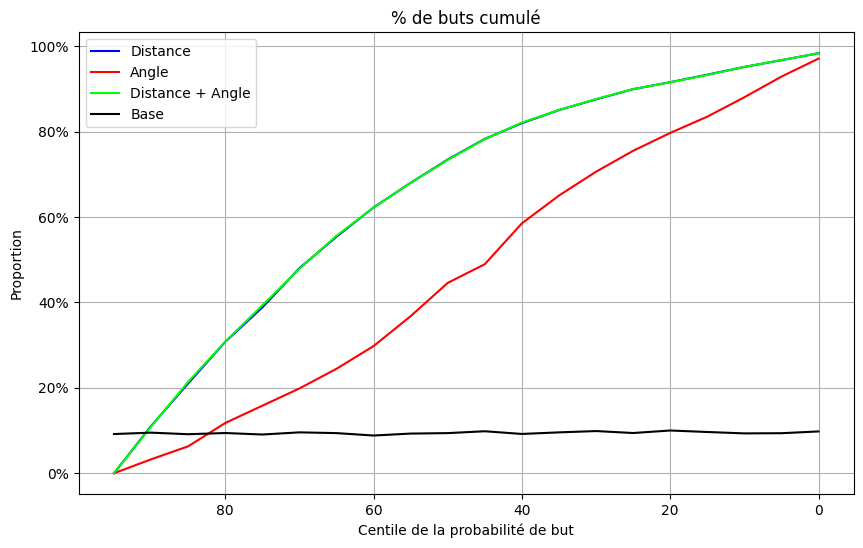

In [16]:
plt.figure(figsize=(10, 6))

# Distance only
percentile_bins, probadf = get_percentile_and_goal_proba(['distance'])
total_shots = probadf['is_goal'].sum()
goals_cums = 1 - probadf.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='Distance')

# Angle only
percentile_bins, probadf = get_percentile_and_goal_proba(['angle_to_goal'])
total_shots = probadf['is_goal'].sum()
goals_cums = 1 - probadf.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.plot(percentile_bins[:-1], goals_cums, color='red', label='Angle')

# Distance + Angle
percentile_bins, probadf = get_percentile_and_goal_proba(['distance', 'angle_to_goal'])
total_shots = probadf['is_goal'].sum()
goals_cums = 1 - probadf.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.plot(percentile_bins[:-1], goals_cums, color='lime', label='Distance + Angle')

# Ligne de base aleatoire
np.random.seed(0)
proba_df = pd.DataFrame({
    'goal_proba': np.random.rand(1000),  # Model's predicted probabilities
    'is_goal': np.random.binomial(1, 0.2, 1000)  # Binary goal indicator (20% goal rate)
})

probadf['goal_proba'] = np.random.uniform(0, 1, size=len(probadf['goal_proba']))
probadf['percentile'] = pd.qcut(probadf['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]) 
total_shots = probadf['is_goal'].sum()
goals_cums = 1 - probadf.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.plot(percentile_bins[:-1], goal_rates_angle_distance, color='black', label='Base')

# Show figure
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

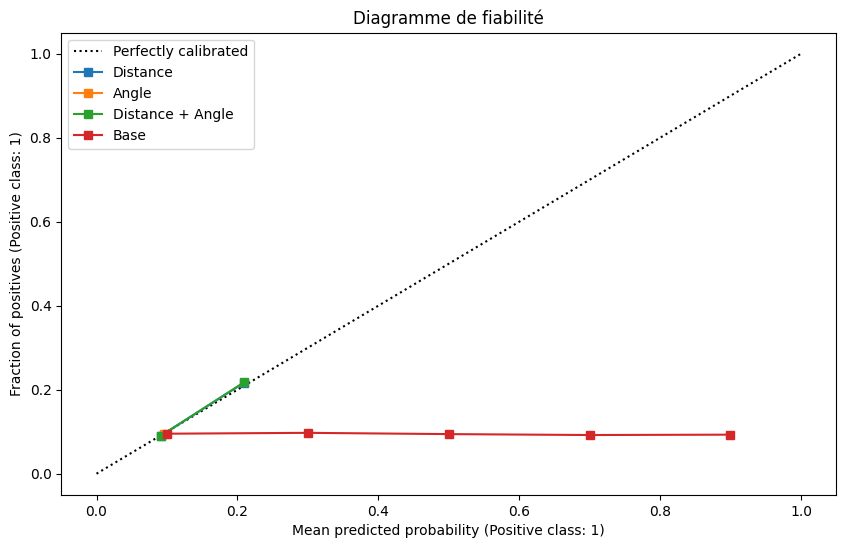

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Distance only
percentile_bins, probadf = get_percentile_and_goal_proba(['distance'])
disp1 = CalibrationDisplay.from_predictions(y_test, probadf['goal_proba'], name="Distance", ax=ax)

# Angle only
percentile_bins, probadf = get_percentile_and_goal_proba(['angle_to_goal'])
disp2 = CalibrationDisplay.from_predictions(y_test, probadf['goal_proba'], name="Angle", ax=ax)

# Distance + Angle
percentile_bins, probadf = get_percentile_and_goal_proba(['distance', 'angle_to_goal'])
disp3 = CalibrationDisplay.from_predictions(y_test, probadf['goal_proba'], name="Distance + Angle", ax=ax)

# Ligne de base aleatoire
np.random.seed(0)
proba_df = pd.DataFrame({
    'goal_proba': np.random.rand(1000),  # Model's predicted probabilities
    'is_goal': np.random.binomial(1, 0.2, 1000)  # Binary goal indicator (20% goal rate)
})

probadf['goal_proba'] = np.random.uniform(0, 1, size=len(probadf['goal_proba']))
probadf['percentile'] = pd.qcut(probadf['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]) 
disp4 = CalibrationDisplay.from_predictions(y_test, probadf['goal_proba'], name="Base", ax=ax)

plt.title("Diagramme de fiabilité")
plt.legend()
plt.show()

###  Wandb

In [18]:
import pickle
import wandb

#### Distance

In [19]:
distance_only_run = wandb.init(
    project='IFT6758.2024-A02',
    name="distance_only_run",
    entity="IFT6758-2024-A02",
    notes="Regression logistique uniquement base sur la distance",
    tags=['base', 'distance'],
)

X = df[['distance']]
y = df['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)
non_goal_proba = [proba[0] for proba in y_proba]
goal_proba = [proba[1] for proba in y_proba]

proba_df = X_test.copy()
proba_df['non_goal_proba'] = non_goal_proba
proba_df['goal_proba'] = goal_proba
proba_df['is_goal'] = y_test

wandb.sklearn.plot_class_proportions(
    y_train,
    y_test,
    [0, 1]
)

model_path = "base_distance.pkl"
with open(model_path,'wb') as f:
    pickle.dump(clf, f)

distance_only_run.log_model(path=model_path, name="base_distance")
os.remove(model_path)

distance_only_run.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nathan-crms (IFT6758-2024-A02). Use `wandb login --relogin` to force relogin


#### Angle du tir

In [20]:
distance_only_run = wandb.init(
    project='IFT6758.2024-A02',
    name="angle_only_run",
    entity="IFT6758-2024-A02",
    notes="Regression logistique uniquement base sur l'angle",
    tags=['base', 'angle'],
)

X = df[['angle_to_goal']]
y = df['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)
non_goal_proba = [proba[0] for proba in y_proba]
goal_proba = [proba[1] for proba in y_proba]

proba_df = X_test.copy()
proba_df['non_goal_proba'] = non_goal_proba
proba_df['goal_proba'] = goal_proba
proba_df['is_goal'] = y_test

wandb.sklearn.plot_class_proportions(
    y_train,
    y_test,
    [0, 1]
)

model_path = "base_angle.pkl"
with open(model_path,'wb') as f:
    pickle.dump(clf, f)

distance_only_run.log_model(path=model_path, name="base_angle")
os.remove(model_path)

distance_only_run.finish()

#### Distance + Angle de tir

In [21]:
distance_only_run = wandb.init(
    project='IFT6758.2024-A02',
    name="angle_and_distance_run",
    entity="IFT6758-2024-A02",
    notes="Regression logistique uniquement base sur la distance et l'angle",
    tags=['base', 'angle-distance'],
)

X = df[['distance', 'angle_to_goal']]
y = df['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)
non_goal_proba = [proba[0] for proba in y_proba]
goal_proba = [proba[1] for proba in y_proba]

proba_df = X_test.copy()
proba_df['non_goal_proba'] = non_goal_proba
proba_df['goal_proba'] = goal_proba
proba_df['is_goal'] = y_test

wandb.sklearn.plot_class_proportions(
    y_train,
    y_test,
    [0, 1]
)

model_path = "base_distance_angle.pkl"
with open(model_path,'wb') as f:
    pickle.dump(clf, f)

distance_only_run.log_model(path=model_path, name="base_distance_angle")
os.remove(model_path)

distance_only_run.finish()